In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
from field_of_junctions import FieldOfJunctions

# Usage demo

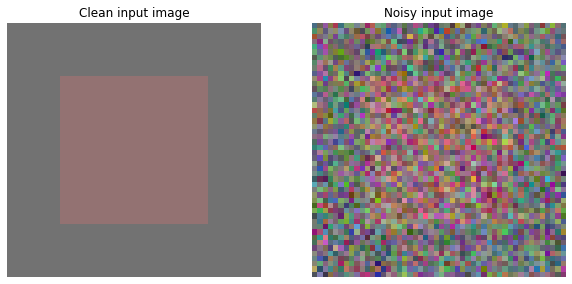

In [5]:
# Red square on black background
clean_img = np.zeros((48, 48, 3), dtype=np.float32)
clean_img[10:-10, 10:-10, 0] = 1.0

# Add noise
img = clean_img + np.random.randn(*clean_img.shape)
mn, mx = img.min(), img.max()

# Adjust contrast (equally to both images)
img = (img - mn) / (mx - mn)
clean_img = (clean_img - mn) / (mx - mn)

plt.figure(figsize=[10, 10])
plt.subplot(121)
plt.imshow(clean_img)
plt.title('Clean input image')
plt.axis('off');
plt.subplot(122)
plt.imshow(img)
plt.title('Noisy input image')
plt.axis('off');

Beginning initialization...
Initialization iteration 0/30
Initialization iteration 5/30
Initialization iteration 10/30
Initialization iteration 15/30
Initialization iteration 20/30
Initialization iteration 25/30
Initialization done. Beginning refinement...
Refinement iteration 100/1000
Refinement iteration 200/1000
Refinement iteration 300/1000
Refinement iteration 400/1000
Refinement iteration 500/1000
Refinement iteration 600/1000
Refinement iteration 700/1000
Refinement iteration 800/1000
Refinement iteration 900/1000
Refinement iteration 1000/1000
CPU times: user 19.3 s, sys: 4.36 s, total: 23.6 s
Wall time: 23.8 s


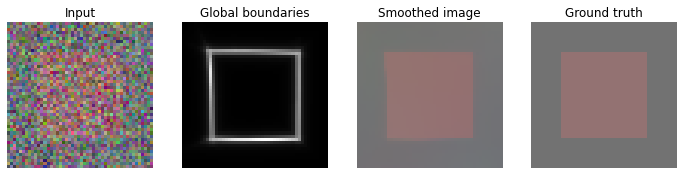

In [6]:
# Create opts object
opts = SimpleNamespace()

opts.R                        = 21
opts.stride                   = 1
opts.eta                      = 0.01
opts.delta                    = 0.05
opts.lr_angles                = 0.003
opts.lr_x0y0                  = 0.03
opts.lambda_final             = 0.5
opts.nvals                    = 31
opts.num_initialization_iters = 30
opts.num_refinement_iters     = 1000
opts.greedy_step_every_iters  = 50
opts.parallel_mode            = True



# Define function for optimization (foj.optimize() may be used instead)
def foj_optimize_verbose():
    for i in range(foj.num_iters):
        if i == 0:
            print("Beginning initialization...")
        if i == opts.num_initialization_iters:
            print("Initialization done. Beginning refinement...")
        if i < opts.num_initialization_iters:
            if i % 5 == 0:
                print(f"Initialization iteration {i}/{opts.num_initialization_iters}")
        else:
            if i % 100 == 0:
                print(f"Refinement iteration {i}/{opts.num_refinement_iters}")
        foj.step(i)

# Create and optimize field of junctions
foj = FieldOfJunctions(img, opts)
%time foj_optimize_verbose()       # Run optimization with some printing

# Compute smoothed image and boundary map
params = torch.cat([foj.angles, foj.x0y0], dim=1)
dists, patches = foj.get_dists_and_patches(params)
local_boundaries = foj.dists2boundaries(dists)
global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()
smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=[12, 12])
plt.subplot(141)
plt.imshow(img)
plt.title('Input')
plt.axis('off')
plt.subplot(142)
plt.imshow(global_boundaries, cmap='gray')
plt.title('Global boundaries')
plt.axis('off')
plt.subplot(143)
plt.imshow(smoothed_img)
plt.title('Smoothed image')
plt.axis('off')
plt.subplot(144)
plt.imshow(clean_img)
plt.title('Ground truth')
plt.axis('off');

# Field of junctions visualization demo

## First, visualize all `RxR` input patches

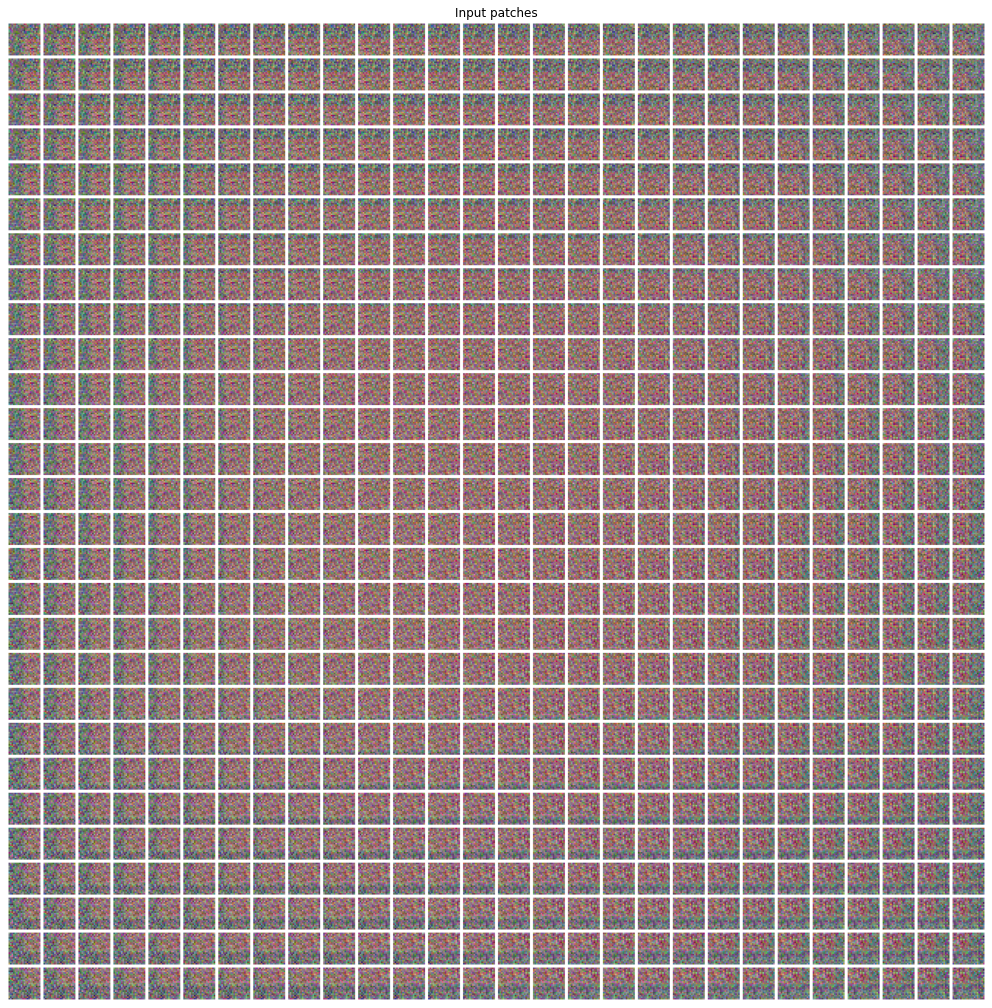

In [7]:
from utils import patchstack

boundary_vis = patchstack(foj.img_patches)[0, :, :, :].detach().permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=[18, 18])
plt.imshow(boundary_vis)
plt.title('Input patches')
plt.axis('off');

## Now visualize the local boundary maps obtained by the field of junctions in all patches

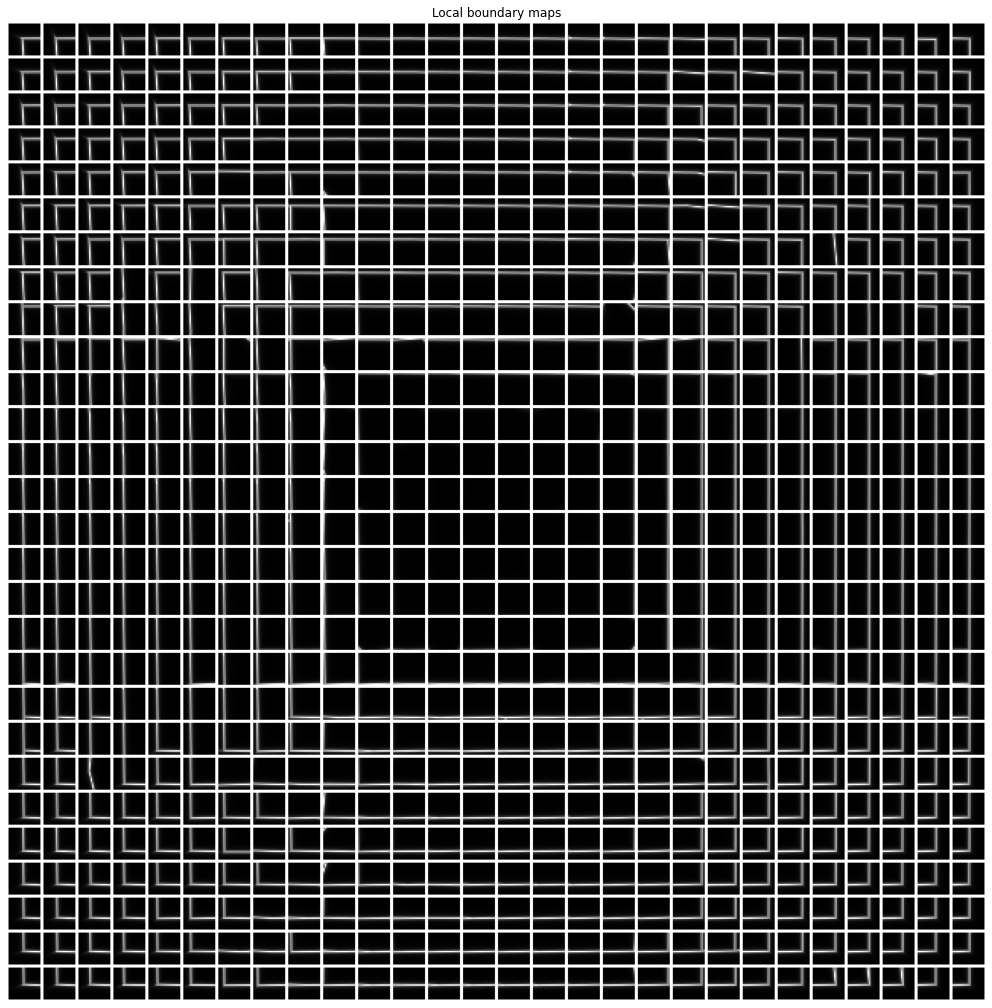

In [8]:
boundary_vis = patchstack(local_boundaries)[0, :, :, :].detach().permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=[18, 18])
plt.imshow(boundary_vis, cmap='gray')
plt.title('Local boundary maps')
plt.axis('off');

# Optimization visualization demo

In [9]:
# Using the exposed foj.step() function it is possible to create a visualization
# of the entire optimization process (here using the imageio package, but you can also use OpenCV's VideoWriter)

import imageio

def foj_optimize_visualize_optimization():
    with imageio.get_writer('optimization.mp4', fps=60, quality=9) as writer:
        for i in range(foj.num_iters):
            if i == 0:
                print("Beginning initialization...")
            if i == opts.num_initialization_iters:
                print("Initialization done. Beginning refinement...")
            if i < opts.num_initialization_iters:
                if i % 5 == 0:
                    print(f"Initialization iteration {i}/{opts.num_initialization_iters}")
            else:
                if i % 100 == 0:
                    print(f"Refinement iteration {i}/{opts.num_refinement_iters}")
            foj.step(i)
            
            # Compute smoothed image and boundaries
            params = torch.cat([foj.angles, foj.x0y0], dim=1)
            dists, patches = foj.get_dists_and_patches(params)
            local_boundaries = foj.dists2boundaries(dists)
            global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()[:, :, np.newaxis].repeat(3, 2)
            smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()
            output = np.concatenate([img, smoothed_img, global_boundaries], axis=1)
            
            writer.append_data(np.uint8(255.0 * output))


# Create and optimize field of junctions
foj = FieldOfJunctions(img, opts)
%time foj_optimize_visualize_optimization()



Beginning initialization...
Initialization iteration 0/30
Initialization iteration 5/30
Initialization iteration 10/30
Initialization iteration 15/30
Initialization iteration 20/30
Initialization iteration 25/30
Initialization done. Beginning refinement...
Refinement iteration 100/1000
Refinement iteration 200/1000
Refinement iteration 300/1000
Refinement iteration 400/1000
Refinement iteration 500/1000
Refinement iteration 600/1000
Refinement iteration 700/1000
Refinement iteration 800/1000
Refinement iteration 900/1000
Refinement iteration 1000/1000
CPU times: user 23.6 s, sys: 4.61 s, total: 28.3 s
Wall time: 30.6 s
